In [1]:
#Importing Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
print(os.listdir("../input"))


['train-data', 'test-data']


In [2]:
#Loading the dataset
train_data = pd.read_csv("../input/train-data/train_cab.csv", sep=",")
test_data  = pd.read_csv("../input/test-data/test.csv", sep=",")

In [3]:
#Missing Value Analysis
missing_val = pd.DataFrame(train_data.isnull().sum())
missing_val = missing_val.reset_index()
missing_val = missing_val.rename(columns={'index':'variables',0:'Missing_values'})
missing_val['Missing_Value_Percentage'] = (missing_val.Missing_values/len(train_data))*100
missing_val = missing_val.sort_values('Missing_Value_Percentage',ascending=False).reset_index(drop=True)
missing_val

,variables,Missing_values,Missing_Value_Percentage
0,passenger_count,55,0.342317
1,fare_amount,24,0.149374
2,pickup_datetime,0,0.000000
3,pickup_longitude,0,0.000000
4,pickup_latitude,0,0.000000
5,dropoff_longitude,0,0.000000
6,dropoff_latitude,0,0.000000


In [4]:
#Dropping Missing values(NA values) very few viables have missing values and its better remove them.
train_data.drop(train_data[train_data.fare_amount.isnull()==True].index,axis=0,inplace=True)
train_data.drop(train_data[train_data.passenger_count.isnull()==True].index,axis=0,inplace=True)

In [5]:
#Rechecking Missing Value 
missing_val = pd.DataFrame(train_data.isnull().sum())
missing_val = missing_val.reset_index()
missing_val = missing_val.rename(columns={'index':'variables',0:'Missing_values'})
missing_val

,variables,Missing_values
0,fare_amount,0
1,pickup_datetime,0
2,pickup_longitude,0
3,pickup_latitude,0
4,dropoff_longitude,0
5,dropoff_latitude,0
6,passenger_count,0


In [6]:
#Checking the Data
train_data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


In [7]:
#Checking the datatypes
train_data.dtypes

fare_amount           object
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      float64
dtype: object

In [8]:
#Reordering incurrect datatypes of Variables
train_data['fare_amount'] = pd.to_numeric(train_data['fare_amount'],errors='coerce')
train_data['pickup_datetime'] = pd.to_datetime(train_data['pickup_datetime'],infer_datetime_format=True,errors='coerce')
train_data['passenger_count'] = train_data['passenger_count'].astype('int')

In [9]:
train_data.dtypes

fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

> > Feature Engineering
- Here pickup and drop locations are related to fare_amont of the data,
- So we need to find the distance using pickup and drop location coordinates by using "Haversine distance formula" 

In [10]:
from math import radians, cos, sin, asin, sqrt
def distance(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    """
    Return distance along great radius between pickup and dropoff coordinates.
    """
    #Define earth radius (km)
    R_earth = 6371
    
    #Convert degrees to radians
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians,
                                                             [pickup_lat, pickup_lon, 
                                                              dropoff_lat, dropoff_lon])
    #Compute distances along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = dropoff_lon - pickup_lon
    
    #Compute haversine distance
    a = np.sin(dlat/2.0)**2 + np.cos(pickup_lat) * np.cos(dropoff_lat) * np.sin(dlon/2.0)**2
    
    return 2 * R_earth * np.arcsin(np.sqrt(a))

def date_time_info(data):
    data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'], format="%Y-%m-%d %H:%M:%S UTC")
    
    data['hour'] = data['pickup_datetime'].dt.hour
    data['day']  = data['pickup_datetime'].dt.day
    data['month'] = data['pickup_datetime'].dt.month
    data['weekday'] = data['pickup_datetime'].dt.weekday
    data['year']    = data['pickup_datetime'].dt.year
    
    return data

#Applying on train_data
train_data = date_time_info(train_data)
train_data['distance'] = distance(train_data['pickup_latitude'], 
                                     train_data['pickup_longitude'],
                                     train_data['dropoff_latitude'] ,
                                     train_data['dropoff_longitude'])
#Preprocessing on test data
#Applying distance and date_time_info function on test_data
test_data = date_time_info(test_data)
test_data['distance'] = distance(test_data['pickup_latitude'], 
                                     test_data['pickup_longitude'],
                                     test_data['dropoff_latitude'] ,
                                     test_data['dropoff_longitude'])

test_key = pd.DataFrame({'key_date':test_data['pickup_datetime']})
test_data = test_data.drop(columns=['pickup_datetime'],axis=1)

train_data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,year,distance
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,17.0,15.0,6.0,0.0,2009.0,1.030764
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,16.0,5.0,1.0,1.0,2010.0,8.450134
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,0.0,18.0,8.0,3.0,2011.0,1.389525
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,4.0,21.0,4.0,5.0,2012.0,2.799270
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,7.0,9.0,3.0,1.0,2010.0,1.999157


In [11]:
#weekday starts from 0 to 6
train_data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,year,distance
count,15987.000000,15988.000000,15988.000000,15988.000000,15988.000000,15988.000000,15987.000000,15987.000000,15987.000000,15987.000000,15987.000000,15988.000000
mean,15.030232,-72.464541,39.915681,-72.464099,39.898780,2.623030,13.498780,15.672984,6.262713,3.034028,2011.728967,16.089651
std,431.200458,10.572946,6.828608,10.569608,6.185996,60.888226,6.520842,8.683288,3.447726,1.968752,1.864156,325.604556
min,-3.000000,-74.438233,-74.006893,-74.429332,-74.006377,0.000000,0.000000,1.000000,1.000000,0.000000,2009.000000,0.000000
25%,6.000000,-73.992143,40.734931,-73.991182,40.734655,1.000000,9.000000,8.000000,3.000000,1.000000,2010.000000,1.214674
50%,8.500000,-73.981691,40.752603,-73.980168,40.753560,1.000000,14.000000,16.000000,6.000000,3.000000,2012.000000,2.125345
75%,12.500000,-73.966822,40.767356,-73.963645,40.768006,2.000000,19.000000,23.000000,9.000000,5.000000,2013.000000,3.847067
max,54343.000000,40.766125,401.083332,40.802437,41.366138,5345.000000,23.000000,31.000000,12.000000,6.000000,2015.000000,8667.542104


1. 1. Checking data distribution Before Outlier Analysis

/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


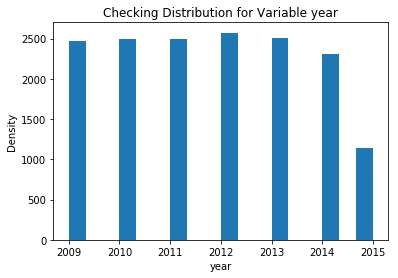

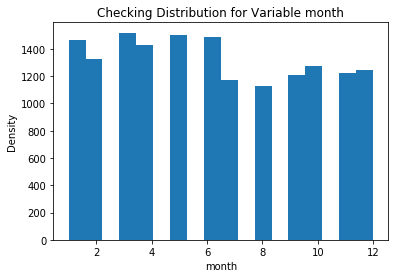

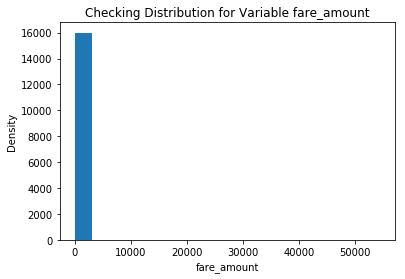

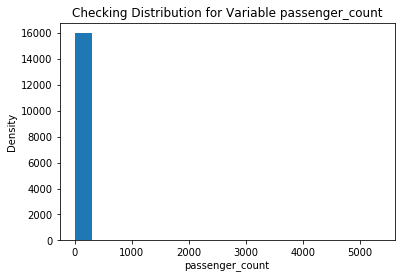

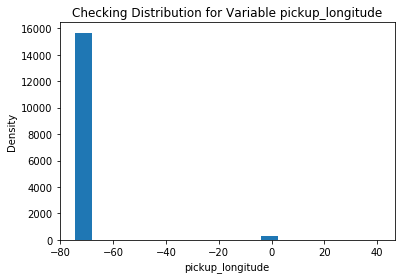

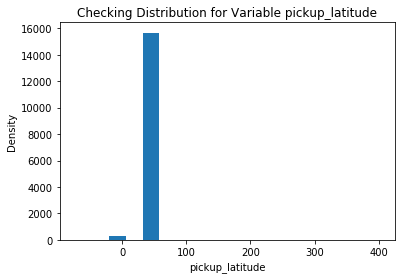

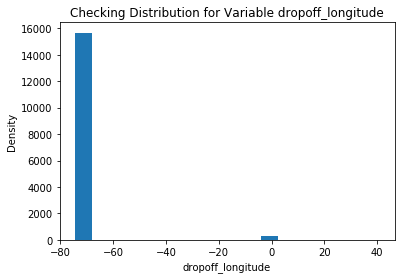

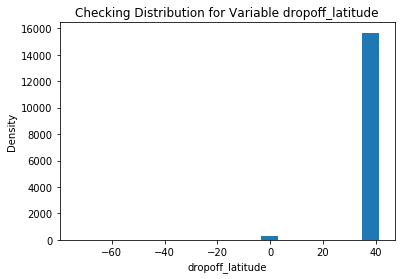

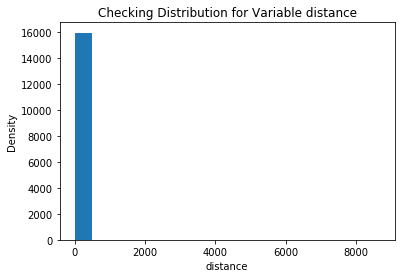

In [12]:
continuous_variables = ['year','month','fare_amount','passenger_count','pickup_longitude',
                        'pickup_latitude','dropoff_longitude','dropoff_latitude','distance']
for i in continuous_variables:
    plt.hist(train_data[i],bins=18)
    plt.title("Checking Distribution for Variable "+str(i))
    plt.ylabel("Density")
    plt.xlabel(i)
    plt.show()

In [13]:
train_data.dtypes

fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
hour                        float64
day                         float64
month                       float64
weekday                     float64
year                        float64
distance                    float64
dtype: object

Outlier Analysis
- from above data fare_amount has negative values and it can't be -ve values 
- Found negative value of fare amount.
  Fare never be negative let's drop those rows which are having negative
  fare amount and also remove outliers
- passenger_count should be  > 0 and < =6
- Latitude should be between min is 40.568973 and max is 41.709555
- Longitude should be min is -74.263242 and max is  -72.986532


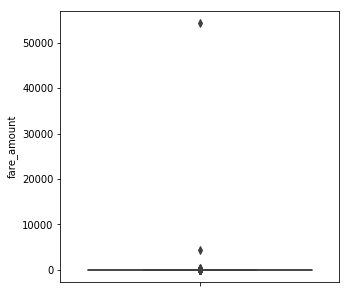

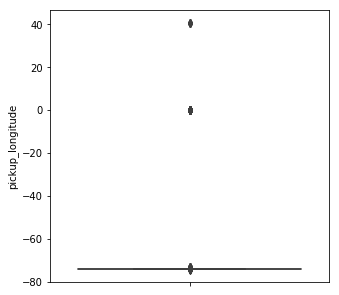

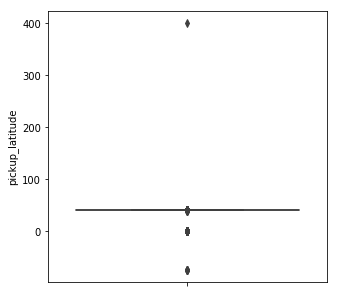

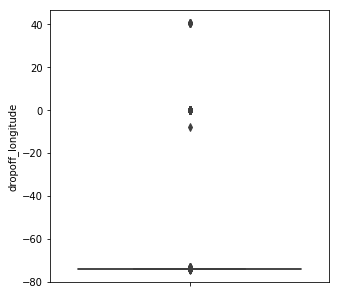

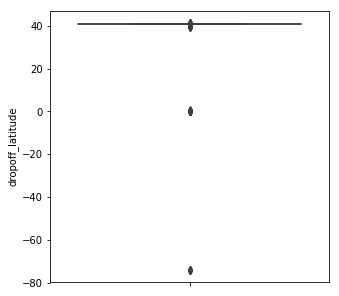

In [14]:
#Outlier Visualizations
col = ['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude']
for i in col:
    sns.boxplot(y=train_data[i])
    fig=plt.gcf()
    fig.set_size_inches(5,5)
    plt.show()

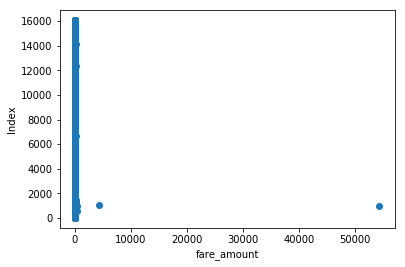

In [15]:
#Fare_amount data distribution by using Scatter plot for all the observations
plt.scatter(x=train_data.fare_amount,y=train_data.index)
plt.ylabel('Index')
plt.xlabel('fare_amount')
plt.show()

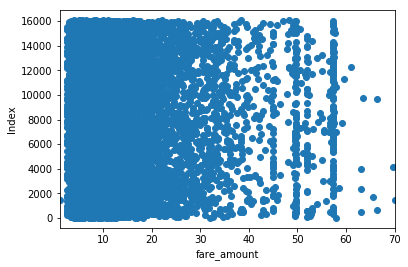

In [16]:
#Fare_amount data distribution by using Scatter plot for selected observations (of x lim range from 1 to 70)
#because from 70 onwards all observations are extreme outliers.
plt.scatter(x=train_data.fare_amount,y=train_data.index)
plt.ylabel('Index')
plt.xlim(1,70)
plt.xlabel('fare_amount')
plt.show()

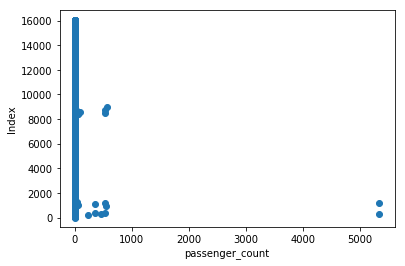

In [17]:
#passenger_count data distribution by using Scatter plot for all the observations,
#because from 70 onwards all observations are extreme outliers.
plt.scatter(x=train_data.passenger_count,y=train_data.index)
plt.ylabel('Index')
plt.xlabel('passenger_count')
plt.show()

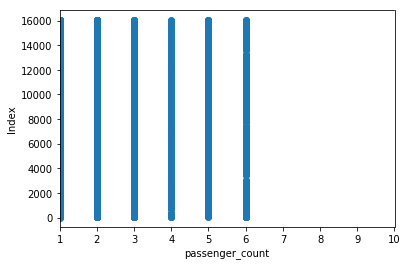

In [18]:
    #passenger_count data distribution by using Scatter plot for sected observations ( x lim range from 1 to 10)
    #because from 70 onwards all observations are extreme outliers.
    plt.scatter(x=train_data.passenger_count,y=train_data.index)
    plt.ylabel('Index')
    plt.xlim(1,10)
    plt.xlabel('passenger_count')
    plt.show()

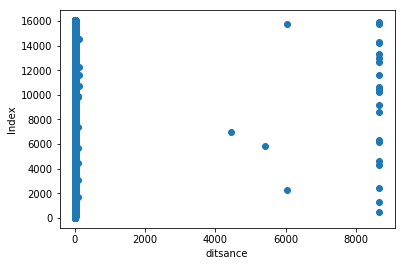

In [19]:
#Scatter plot for distance variable for all the observations
plt.scatter(x=train_data.distance,y=train_data.index)
plt.ylabel('Index')
#plt.xlim(1,10)
plt.xlabel('ditsance')
plt.show()

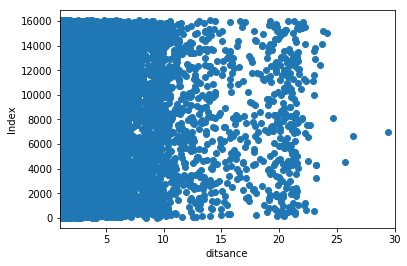

In [20]:
    #Scatter plot for distance variable for selected index range of observations
    plt.scatter(x=train_data.distance,y=train_data.index)
    plt.ylabel('Index')
    plt.xlim(1,30)
    plt.xlabel('ditsance')
    plt.show()

Manualy removing outliers based on the test data feature conditions

In [21]:
#Finding the longitude min and max of test data
lon_min=min(test_data.pickup_longitude.min(),test_data.dropoff_longitude.min())
lon_max=max(test_data.pickup_longitude.max(),test_data.dropoff_longitude.max())
print(lon_min,',',lon_max)

#Finding the latitude min and max of test data
lat_min=min(test_data.pickup_latitude.min(),test_data.dropoff_latitude.min())
lat_max=max(test_data.pickup_latitude.max(),test_data.dropoff_latitude.max())
print(lat_min,',',lat_max)

-74.263242 , -72.986532
40.568973 , 41.709555


In [22]:
train_data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,year,distance
count,15987.000000,15988.000000,15988.000000,15988.000000,15988.000000,15988.000000,15987.000000,15987.000000,15987.000000,15987.000000,15987.000000,15988.000000
mean,15.030232,-72.464541,39.915681,-72.464099,39.898780,2.623030,13.498780,15.672984,6.262713,3.034028,2011.728967,16.089651
std,431.200458,10.572946,6.828608,10.569608,6.185996,60.888226,6.520842,8.683288,3.447726,1.968752,1.864156,325.604556
min,-3.000000,-74.438233,-74.006893,-74.429332,-74.006377,0.000000,0.000000,1.000000,1.000000,0.000000,2009.000000,0.000000
25%,6.000000,-73.992143,40.734931,-73.991182,40.734655,1.000000,9.000000,8.000000,3.000000,1.000000,2010.000000,1.214674
50%,8.500000,-73.981691,40.752603,-73.980168,40.753560,1.000000,14.000000,16.000000,6.000000,3.000000,2012.000000,2.125345
75%,12.500000,-73.966822,40.767356,-73.963645,40.768006,2.000000,19.000000,23.000000,9.000000,5.000000,2013.000000,3.847067
max,54343.000000,40.766125,401.083332,40.802437,41.366138,5345.000000,23.000000,31.000000,12.000000,6.000000,2015.000000,8667.542104


In [23]:
#1 - Removing -ve values from the fare_amount variable
train_data_new = train_data  
train_data=train_data.drop(train_data[(train_data.fare_amount<=0) | (train_data.fare_amount>=65)].index,axis=0)

#2 - Removing null values from passenger count
#From the the test data passenger count lies between min is 1 and max is 6 
train_data=train_data.drop(train_data[(train_data.passenger_count<=0) | (train_data.passenger_count>6)].index,axis=0)

#4 - Removing pickup_latitude,dropoff_latitude, pickup_longitude, and dropoff_longitude
train_data=train_data.drop(train_data[(train_data.pickup_latitude <lat_min)| (train_data.pickup_latitude >lat_max)].index,axis=0)
train_data=train_data.drop(train_data[(train_data.dropoff_latitude <lat_min) | (train_data.dropoff_latitude >lat_max)].index,axis=0)
train_data=train_data.drop(train_data[(train_data.pickup_longitude <lon_min) | (train_data.pickup_longitude >lon_max)].index,axis=0)
train_data=train_data.drop(train_data[(train_data.dropoff_longitude <lon_min) | (train_data.dropoff_longitude >lon_max)].index,axis=0)

#4 - Removing Outliers in the Distance variable outliers
train_data=train_data.drop(train_data[(train_data.distance <=0)].index,axis=0)


In [24]:
train_data.shape

(15379, 13)

In [25]:
train_data.isna().sum()

fare_amount          1
pickup_datetime      1
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
hour                 1
day                  1
month                1
weekday              1
year                 1
distance             0
dtype: int64

In [26]:
    train_data.dropna(axis=0,inplace=True)
    train_data.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
hour                 0
day                  0
month                0
weekday              0
year                 0
distance             0
dtype: int64

In [27]:
train_data.shape

(15377, 13)

In [28]:
train_data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,year,distance
count,15377.000000,15377.000000,15377.000000,15377.000000,15377.000000,15377.000000,15377.000000,15377.000000,15377.00000,15377.000000,15377.000000,15377.000000
mean,11.194632,-73.975183,40.751201,-73.974113,40.751765,1.652338,13.502244,15.668466,6.27229,3.036873,2011.738766,3.383231
std,8.989865,0.037724,0.029170,0.034575,0.031116,1.268141,6.512755,8.684536,3.44919,1.970221,1.871517,4.072176
min,0.010000,-74.229138,40.572183,-74.227047,40.574652,1.000000,0.000000,1.000000,1.00000,0.000000,2009.000000,0.000111
25%,6.000000,-73.992375,40.736687,-73.991348,40.736500,1.000000,9.000000,8.000000,3.00000,1.000000,2010.000000,1.276522
50%,8.500000,-73.982085,40.753448,-73.980570,40.754297,1.000000,14.000000,16.000000,6.00000,3.000000,2012.000000,2.188903
75%,12.500000,-73.968205,40.767805,-73.965572,40.768342,2.000000,19.000000,23.000000,9.00000,5.000000,2013.000000,3.915699
max,63.500000,-73.137393,41.366138,-73.137393,41.366138,6.000000,23.000000,31.000000,12.00000,6.000000,2015.000000,101.094619


In [29]:
test_data.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,year,distance
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273,13.467420,16.194170,6.857979,2.852834,2011.815816,3.435371
std,0.042774,0.033541,0.039072,0.035435,1.278747,6.868584,8.838482,3.353272,1.994451,1.803347,3.972374
min,-74.252193,40.573143,-74.263242,40.568973,1.000000,0.000000,1.000000,1.000000,0.000000,2009.000000,0.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000,8.000000,9.000000,4.000000,1.000000,2010.000000,1.298277
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000,15.000000,16.000000,7.000000,3.000000,2012.000000,2.217412
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000,19.000000,25.000000,10.000000,5.000000,2014.000000,4.045302
max,-72.986532,41.709555,-72.990963,41.696683,6.000000,23.000000,31.000000,12.000000,6.000000,2015.000000,99.996040


Checking data distribution after Outlier Analysis

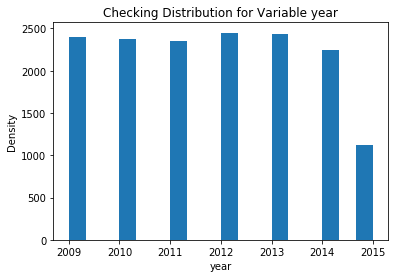

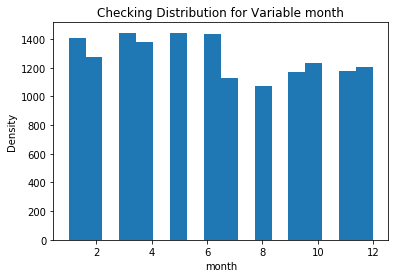

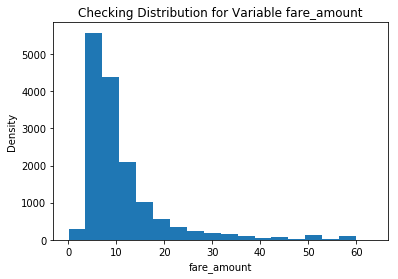

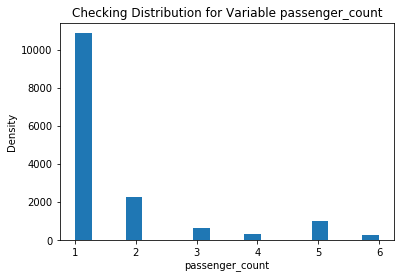

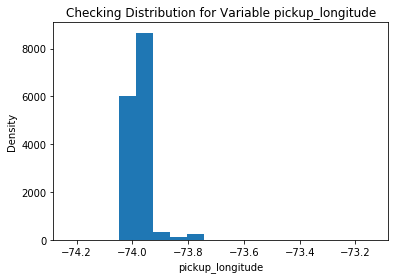

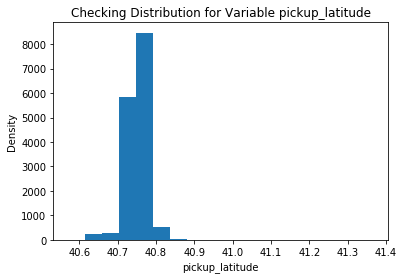

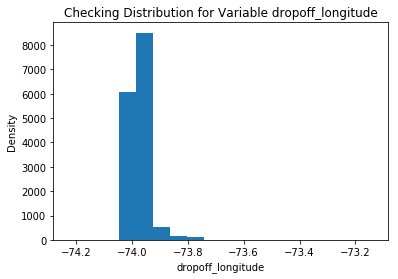

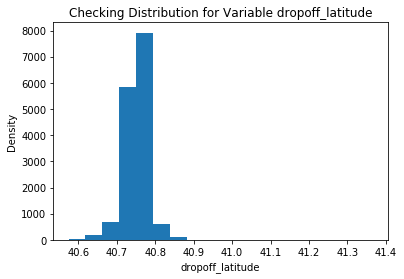

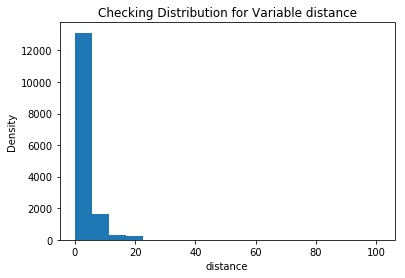

In [30]:
continuous_variables = ['year','month','fare_amount','passenger_count','pickup_longitude',
                        'pickup_latitude','dropoff_longitude','dropoff_latitude','distance']
for i in continuous_variables:
    plt.hist(train_data[i],bins=18)
    plt.title("Checking Distribution for Variable "+str(i))
    plt.ylabel("Density")
    plt.xlabel(i)
    plt.show()

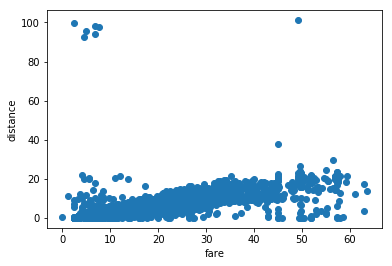

In [31]:
#Plot for fare_amount variation across distance
plt.scatter(y=train_data['distance'],x=train_data['fare_amount'])
plt.xlabel('fare')
plt.ylabel('distance')
plt.show()

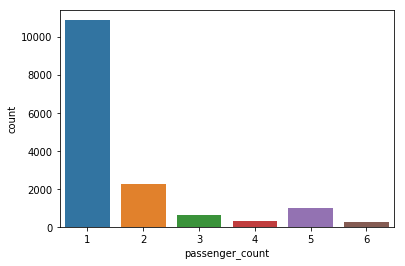

In [32]:
sns.countplot(train_data['passenger_count'])

    **Asumptions for Hypothesis**

In [33]:
train_data.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'hour',
       'day', 'month', 'weekday', 'year', 'distance'],
      dtype='object')

    1)Check the pickup date and time affect the fare or not

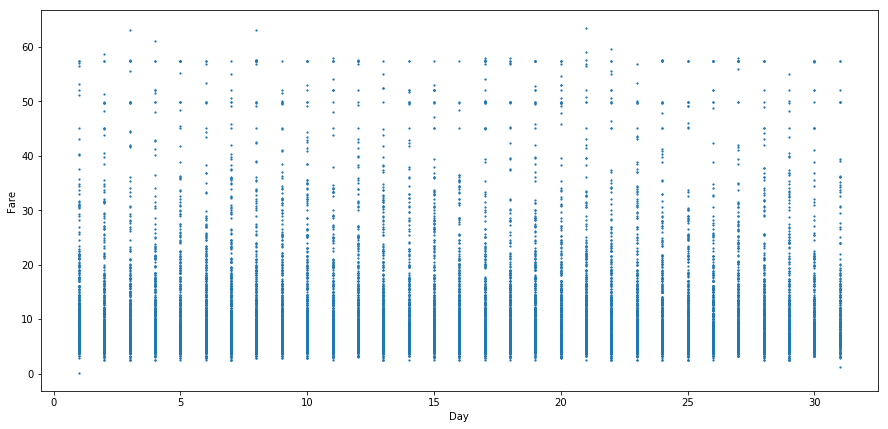

In [34]:
plt.figure(figsize=(15,7))
plt.scatter(x=train_data['day'], y=train_data['fare_amount'], s=1.5)
plt.xlabel('Day')
plt.ylabel('Fare')
plt.show()

The fares throught the month mostly seem uniform



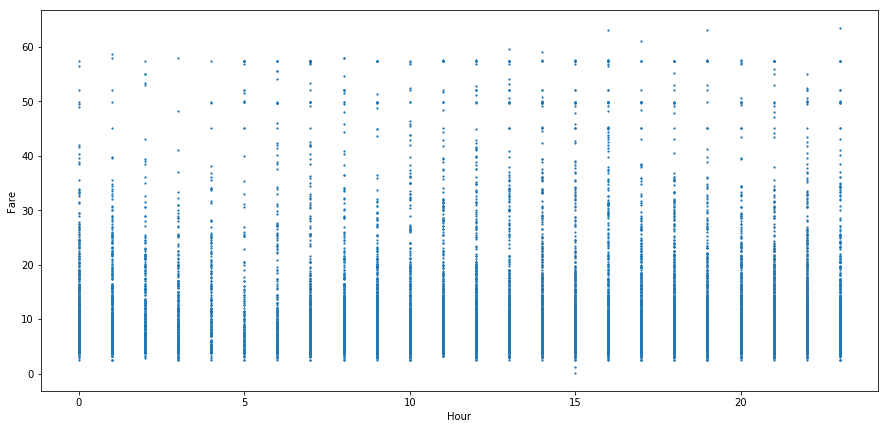

In [35]:
    plt.figure(figsize=(15,7))
    plt.scatter(x=train_data['hour'], y=train_data['fare_amount'], s=1.5)
    plt.xlabel('Hour')
    plt.ylabel('Fare')
    plt.show()

The time of day definitely plays an important role. The frequency of cab rides seem to be the lowest at 5AM

![](http://)2 - Number of Passengers vs Fare

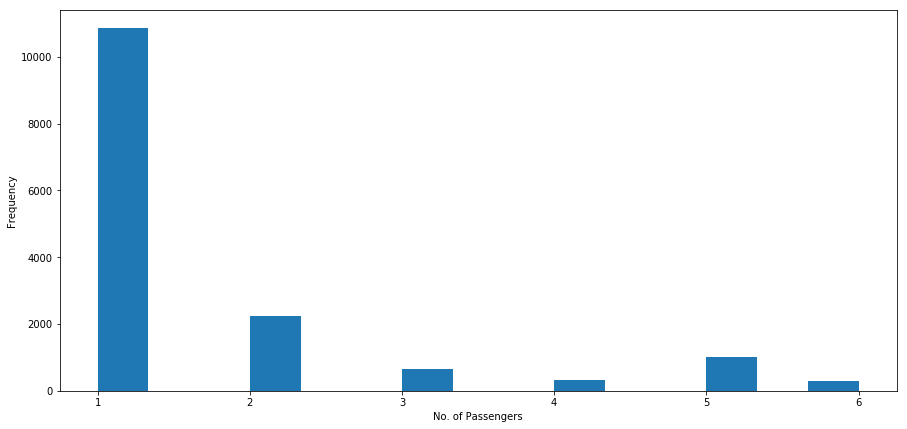

In [36]:
    plt.figure(figsize=(15,7))
    plt.hist(train_data['passenger_count'], bins=15)
    plt.xlabel('No. of Passengers')
    plt.ylabel('Frequency')
    plt.show()

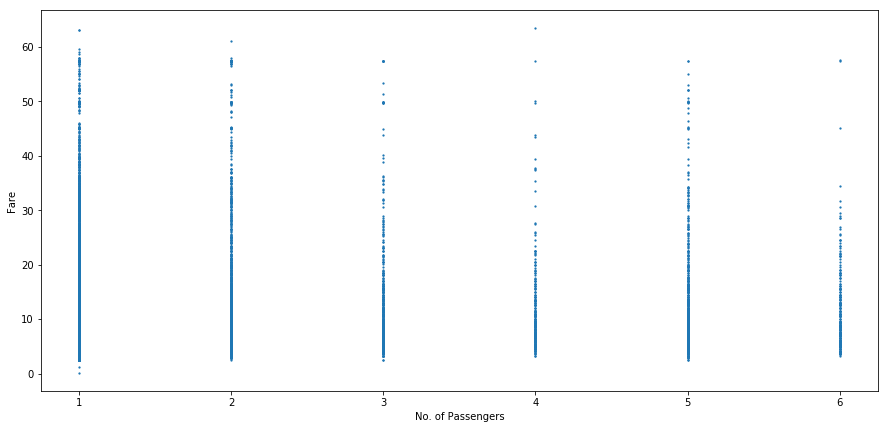

In [37]:
plt.figure(figsize=(15,7))
plt.scatter(x=train_data['passenger_count'], y=train_data['fare_amount'], s=1.5)
plt.xlabel('No. of Passengers')
plt.ylabel('Fare')
plt.show()

single passengers are the most frequent travellers, and the highest fare also seems to come from cabs which carry just 1 passenger.



    3 - Does the day of the week affect the fare?


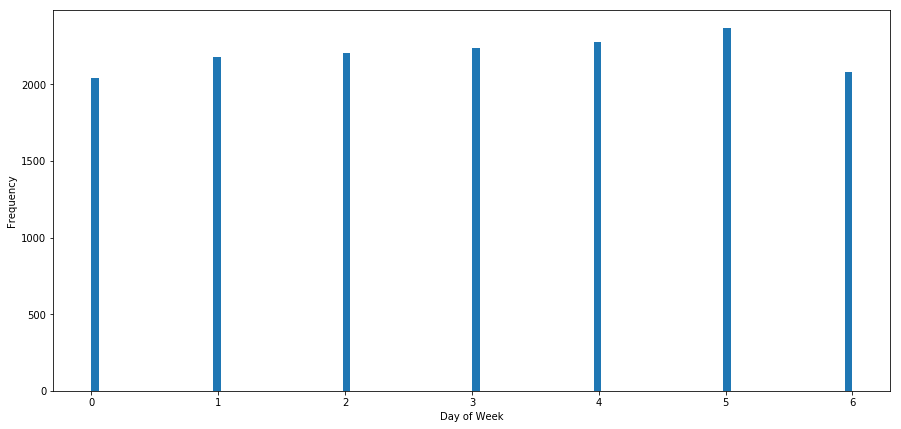

In [38]:
plt.figure(figsize=(15,7))
plt.hist(train_data['weekday'], bins=100)
plt.xlabel('Day of Week')
plt.ylabel('Frequency')
plt.show()

day of the week doesn't seem to have the effect on the number of cab rides



**Feature Scaling**

(array([1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 4.100e+01, 6.100e+01,
        1.920e+02, 6.690e+02, 6.470e+02, 7.410e+02, 1.245e+03, 7.960e+02,
        7.400e+02, 7.390e+02, 1.017e+03, 6.480e+02, 6.070e+02, 7.970e+02,
        4.860e+02, 4.250e+02, 5.640e+02, 3.800e+02, 2.990e+02, 2.930e+02,
        5.000e+02, 2.260e+02, 1.810e+02, 2.130e+02, 1.540e+02, 1.380e+02,
        2.040e+02, 1.410e+02, 1.210e+02, 1.370e+02, 8.100e+01, 9.000e+01,
        7.300e+01, 9.700e+01, 6.900e+01, 6.200e+01, 8.300e+01, 6.900e+01,
        4.000e+01, 5.500e+01, 3.800e+01, 4.000e+01, 4.600e+01, 4.400e+01,
        6.100e+01, 3.200e+01, 3.900e+01, 3.800e+01, 2.200e+01, 3.700e+01,
        2.600e+01, 2.900e+01, 1.700e+01, 2.900e+01, 3.300e+01, 2.300e+01,
        3.700e+01, 2.700e+01, 1.800e+01, 3.300e+01, 3.300e+01, 1.800e+01,
        1.800e+01, 1.700e+01, 2.200e+01, 1.700e+01, 1.100e+01, 1.200e+01,
        9.000e+00, 1.500e+01, 9.000e+00, 1.100e+01, 1.000e+01, 6.000e+00,
        6.000e+00, 7.000e+00, 1.000e+0

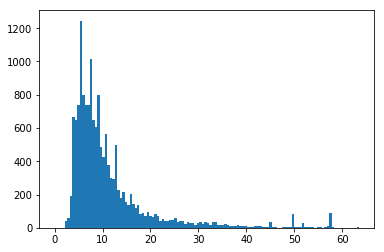

In [39]:
#Normality check
#%matplotlib inline  
plt.hist(train_data['fare_amount'], bins='auto')


In [40]:
#taking copy of the data
train_data_df = train_data.copy()

In [41]:
#Nomalization
"""
cnames =['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'hour',
       'day', 'month', 'weekday', 'year', 'distance']
for i in cnames:
    print(i)
    train_data[i] = (train_data[i] - min(train_data[i]))/(max(train_data[i]) - min(train_data[i]))
"""

"\ncnames =['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',\n       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'hour',\n       'day', 'month', 'weekday', 'year', 'distance']\nfor i in cnames:\n    print(i)\n    train_data[i] = (train_data[i] - min(train_data[i]))/(max(train_data[i]) - min(train_data[i]))\n"

In [42]:
#train_data = train_data_df.copy()
#correlation between numerical variables
num = pd.DataFrame(train_data.select_dtypes(include=np.number))
cor = num.corr()        
cor

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,year,distance
fare_amount,1.000000,0.408673,-0.205860,0.373801,-0.152296,0.011001,-0.031658,-0.006285,0.035871,0.004981,0.124713,0.775291
pickup_longitude,0.408673,1.000000,0.132342,0.249069,0.054837,-0.001138,0.019615,0.004809,0.005742,-0.037876,0.007045,0.535682
pickup_latitude,-0.205860,0.132342,1.000000,0.063874,0.375640,-0.006778,0.036162,-0.008156,-0.002605,-0.050129,-0.019233,-0.044455
dropoff_longitude,0.373801,0.249069,0.063874,1.000000,0.199988,-0.005142,-0.052441,0.009721,0.017369,0.003140,0.007233,0.423682
dropoff_latitude,-0.152296,0.054837,0.375640,0.199988,1.000000,-0.003610,0.017545,0.000863,0.006670,-0.017540,0.001388,-0.055983
passenger_count,0.011001,-0.001138,-0.006778,-0.005142,-0.003610,1.000000,0.018277,0.001805,0.008976,0.041912,0.001766,0.000382
hour,-0.031658,0.019615,0.036162,-0.052441,0.017545,0.018277,1.000000,0.000075,-0.002961,-0.089143,-0.003935,-0.039689
day,-0.006285,0.004809,-0.008156,0.009721,0.000863,0.001805,0.000075,1.000000,-0.016446,0.013892,-0.026765,-0.004985
month,0.035871,0.005742,-0.002605,0.017369,0.006670,0.008976,-0.002961,-0.016446,1.000000,-0.015546,-0.116258,0.017435
weekday,0.004981,-0.037876,-0.050129,0.003140,-0.017540,0.041912,-0.089143,0.013892,-0.015546,1.000000,0.004958,0.013418


In [43]:
num

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,year,distance
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,17.0,15.0,6.0,0.0,2009.0,1.030764
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,16.0,5.0,1.0,1.0,2010.0,8.450134
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,0.0,18.0,8.0,3.0,2011.0,1.389525
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,4.0,21.0,4.0,5.0,2012.0,2.799270
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,7.0,9.0,3.0,1.0,2010.0,1.999157
5,12.1,-74.000964,40.731630,-73.972892,40.758233,1,9.0,6.0,1.0,3.0,2011.0,3.787239
6,7.5,-73.980002,40.751662,-73.973802,40.764842,1,20.0,20.0,11.0,1.0,2012.0,1.555807
7,16.5,-73.951300,40.774138,-73.990095,40.751048,1,17.0,4.0,1.0,2.0,2012.0,4.155444
9,8.9,-73.980658,40.733873,-73.991540,40.758138,2,1.0,2.0,9.0,2.0,2009.0,2.849627
10,5.3,-73.996335,40.737142,-73.980721,40.733559,1,7.0,8.0,4.0,6.0,2012.0,1.374577


In [44]:
train_data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,year,distance
count,15377.000000,15377.000000,15377.000000,15377.000000,15377.000000,15377.000000,15377.000000,15377.000000,15377.00000,15377.000000,15377.000000,15377.000000
mean,11.194632,-73.975183,40.751201,-73.974113,40.751765,1.652338,13.502244,15.668466,6.27229,3.036873,2011.738766,3.383231
std,8.989865,0.037724,0.029170,0.034575,0.031116,1.268141,6.512755,8.684536,3.44919,1.970221,1.871517,4.072176
min,0.010000,-74.229138,40.572183,-74.227047,40.574652,1.000000,0.000000,1.000000,1.00000,0.000000,2009.000000,0.000111
25%,6.000000,-73.992375,40.736687,-73.991348,40.736500,1.000000,9.000000,8.000000,3.00000,1.000000,2010.000000,1.276522
50%,8.500000,-73.982085,40.753448,-73.980570,40.754297,1.000000,14.000000,16.000000,6.00000,3.000000,2012.000000,2.188903
75%,12.500000,-73.968205,40.767805,-73.965572,40.768342,2.000000,19.000000,23.000000,9.00000,5.000000,2013.000000,3.915699
max,63.500000,-73.137393,41.366138,-73.137393,41.366138,6.000000,23.000000,31.000000,12.00000,6.000000,2015.000000,101.094619


[]

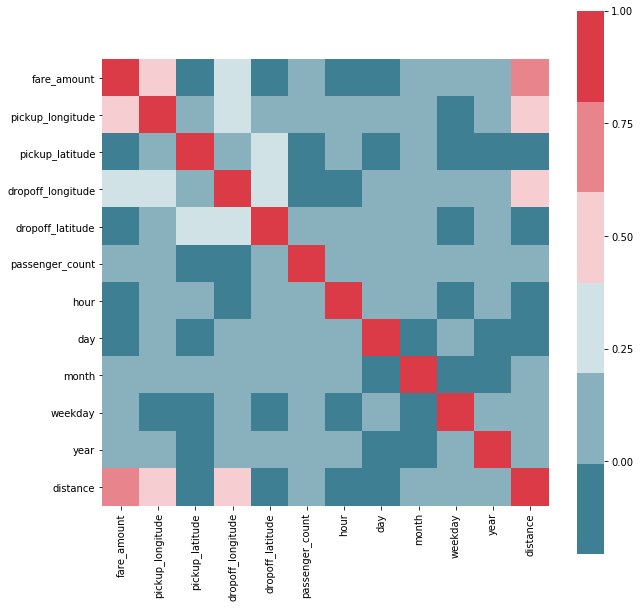

In [45]:
#Coorelation Plot to check the Coorelation
continuous_variables =['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'hour',
       'day', 'month', 'weekday', 'year', 'distance']

df_cor = train_data.loc[:,continuous_variables]
f, ax = plt.subplots(figsize=(10,10))

#Generate correlation matrix
cor_mat = df_cor.corr()

#Plot using seaborn library
sns.heatmap(cor_mat, mask=np.zeros_like(cor_mat, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=False),
            square=True, ax=ax)
plt.plot()

In [46]:
train_data.passenger_count

0        1
1        1
2        2
3        1
4        1
5        1
6        1
7        1
9        2
10       1
12       2
13       1
14       2
16       1
17       1
18       1
19       1
20       1
21       1
22       1
23       1
24       1
25       3
27       3
28       1
29       2
30       1
32       3
33       2
34       1
        ..
16035    1
16036    1
16037    1
16038    1
16039    5
16040    1
16041    1
16042    2
16043    2
16044    1
16045    2
16046    1
16047    1
16048    1
16049    4
16050    1
16051    2
16052    5
16053    1
16054    1
16055    1
16057    6
16058    2
16059    3
16060    1
16061    1
16062    1
16063    2
16064    1
16065    1
Name: passenger_count, Length: 15377, dtype: int64

In [47]:
#VIF to check the Correlation
#pick_up date is correlated to its extracted columns i.e day, year, month, weekday
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X = add_constant(num)
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

const                1.921785e+07
fare_amount          2.899409e+00
pickup_longitude     1.461893e+00
pickup_latitude      1.267572e+00
dropoff_longitude    1.324546e+00
dropoff_latitude     1.249912e+00
passenger_count      1.002682e+00
hour                 1.014675e+00
day                  1.001724e+00
month                1.018722e+00
weekday              1.014930e+00
year                 1.057942e+00
distance             3.143368e+00
dtype: float64

Feature Selection

In [48]:
#Removing variable 'Pickup datetime' beacause day,year,month carries all the information  from it
del train_data['pickup_datetime']

#Selected variables for model building
train_data.columns

"""
Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'hour',
       'day', 'month', 'weekday', 'year', 'distance'],
      dtype='object')
"""

"\nIndex(['fare_amount', 'pickup_longitude', 'pickup_latitude',\n       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'hour',\n       'day', 'month', 'weekday', 'year', 'distance'],\n      dtype='object')\n"

In [49]:
train_data.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'hour',
       'day', 'month', 'weekday', 'year', 'distance'],
      dtype='object')

Model Building for Train data

In [50]:
#Splitting data into test and train
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

#-> For Train data -> train_data

y = train_data['fare_amount']
X = train_data.drop(columns=['fare_amount'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

def evaluate(model, test_features, test_actual):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_actual)
    rmse = np.sqrt(mean_squared_error(test_actual,predictions))
    mape = 100 * np.mean(errors / test_actual)
    accuracy = 100 - mape
    rsquared = r2_score(test_actual, predictions)
    df_pred = pd.DataFrame({'actual':test_actual,'predicted':predictions})
    print('<---Model Performance--->')
    print('R-Squared Value = {:0.2f}'.format(rsquared))
    print('RMSE = {:0.2f}'.format(rmse))
    print('MAPE = {:0.2f}'.format(mape))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return rmse


In [51]:
#Linear regression
from sklearn.linear_model import LinearRegression
model_lr = LinearRegression().fit(X_train,y_train)

#predicting and testing on train data
evaluate(model_lr, X_test, y_test)


<---Model Performance--->
R-Squared Value = 0.66
RMSE = 5.30
MAPE = 30.61
Accuracy = 69.39%.


5.299969860848982

In [52]:
#Decision Tree
from sklearn.tree import DecisionTreeRegressor
model_dt = DecisionTreeRegressor(random_state = 123).fit(X_train,y_train)

#predicting and testing on train data
evaluate(model_dt, X_test, y_test)


<---Model Performance--->
R-Squared Value = 0.65
RMSE = 5.33
MAPE = 29.08
Accuracy = 70.92%.


5.33370105743573

In [53]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor().fit(X_train,y_train)

#predicting and testing on train data
evaluate(model_rf, X_test, y_test)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


<---Model Performance--->
R-Squared Value = 0.81
RMSE = 3.96
MAPE = 21.89
Accuracy = 78.11%.


3.9597423337232236

In [54]:
#Parameters of base model
model_rf.get_params()

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [55]:
X_train.columns

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'hour', 'day', 'month',
       'weekday', 'year', 'distance'],
      dtype='object')

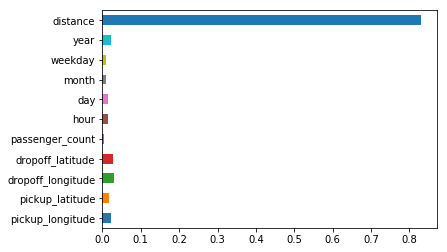

In [56]:
#Printing Feature importance of the model
feat_importances = pd.Series(model_rf.feature_importances_, index=X_train.columns)
feat_importances.plot(kind='barh')

**Hyper Parameter tuning**

In [57]:
#Hyperparameter tuning using GridSearchCV
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [20, 25, 30],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [2,3],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [300,500,600,800]
}
# Create a base model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [58]:
grid_search.fit(X_train,y_train)
grid_search.best_params_
best_grid = grid_search.best_estimator_

#Applying gridsearchcsv to test data
grid_accuracy = evaluate(best_grid,X_test, y_test)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 18.3min
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 44.2min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed: 49.1min finished


<---Model Performance--->
R-Squared Value = 0.83
RMSE = 3.74
MAPE = 19.95
Accuracy = 80.05%.


In [59]:
#Getting the best Parameters
#grid_search.best_params_
#or
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=8,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

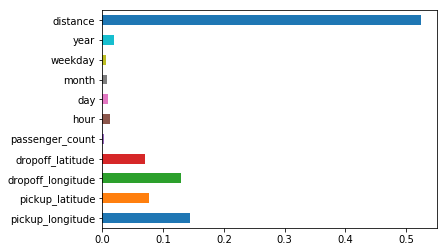

In [60]:
    #Printing Feature importance by visualizations
    feat_importances_hyp = pd.Series(grid_search.best_estimator_.feature_importances_, index=X_train.columns)
    feat_importances_hyp.plot(kind='barh')

    **Applying hyperparameters tuned  base model on test data **

In [61]:
#Building Random Forest model with hypertuned parameters
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False).fit(X_train,y_train)

#predicting and testing on train data
evaluate(model_rf, X_test, y_test)


<---Model Performance--->
R-Squared Value = 0.83
RMSE = 3.75
MAPE = 20.06
Accuracy = 79.94%.


3.752555029788442

**Predicting on given test data **

In [62]:
#Checking the given test data
test_data.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,year,distance
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273,13.467420,16.194170,6.857979,2.852834,2011.815816,3.435371
std,0.042774,0.033541,0.039072,0.035435,1.278747,6.868584,8.838482,3.353272,1.994451,1.803347,3.972374
min,-74.252193,40.573143,-74.263242,40.568973,1.000000,0.000000,1.000000,1.000000,0.000000,2009.000000,0.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000,8.000000,9.000000,4.000000,1.000000,2010.000000,1.298277
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000,15.000000,16.000000,7.000000,3.000000,2012.000000,2.217412
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000,19.000000,25.000000,10.000000,5.000000,2014.000000,4.045302
max,-72.986532,41.709555,-72.990963,41.696683,6.000000,23.000000,31.000000,12.000000,6.000000,2015.000000,99.996040


In [63]:
    predictions = model_rf.predict(test_data)
    predicted_test = pd.DataFrame({'pickup_datetime':test_key['key_date'],'Predicted_Fare':predictions})
    predicted_test.head(10)

,pickup_datetime,Predicted_Fare
0,2015-01-27 13:08:24,10.002729
1,2015-01-27 13:08:24,9.945706
2,2011-10-08 11:53:44,4.926157
3,2012-12-01 21:12:12,8.752492
4,2012-12-01 21:12:12,15.279321
5,2012-12-01 21:12:12,10.613258
6,2011-10-06 12:10:20,5.159299
7,2011-10-06 12:10:20,48.395848
8,2011-10-06 12:10:20,11.866573
9,2014-02-18 15:22:20,6.420407
